In [22]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib as mpl
import time
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from PIL import Image
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

try:
    import cust_f
except:
    pass
# to perform multiprocessing using a customized function (not necessary for Linux)

tot_run_time_start = time.time()

# 데이터 가져오기

In [7]:
with open("../btc_usd_1d.pkl","rb") as fr:
    data = pickle.load(fr)
print(data)

                Open      High       Low     Close        Volume   Datetime
Datetime                                                                   
2017-01-01    966.34   1005.00    960.53    998.80  6.579904e+06 2017-01-01
2017-01-02    997.75   1032.00    990.01   1014.10  8.190255e+06 2017-01-02
2017-01-03   1011.44   1039.00    999.99   1036.99  8.955193e+06 2017-01-03
2017-01-04   1035.51   1139.89   1028.56   1122.56  2.325716e+07 2017-01-04
2017-01-05   1114.38   1136.72    885.41    994.02  3.503690e+07 2017-01-05
...              ...       ...       ...       ...           ...        ...
2022-05-12  29077.90  30257.00  26631.00  29020.70  9.644756e+05 2022-05-12
2022-05-13  29020.80  31072.60  28730.40  29274.30  5.076201e+05 2022-05-13
2022-05-14  29274.20  30352.20  28602.30  30079.80  3.157569e+05 2022-05-14
2022-05-15  30079.50  31462.00  29448.00  31324.40  3.367731e+05 2022-05-15
2022-05-16  31324.30  31327.40  29280.00  29851.50  1.971161e+05 2022-05-16

[1962 rows 

In [8]:
data

,Open,High,Low,Close,Volume,Datetime
Datetime,,,,,,
2017-01-01,966.34,1005.00,960.53,998.80,6.579904e+06,2017-01-01
2017-01-02,997.75,1032.00,990.01,1014.10,8.190255e+06,2017-01-02
2017-01-03,1011.44,1039.00,999.99,1036.99,8.955193e+06,2017-01-03
2017-01-04,1035.51,1139.89,1028.56,1122.56,2.325716e+07,2017-01-04
2017-01-05,1114.38,1136.72,885.41,994.02,3.503690e+07,2017-01-05
...,...,...,...,...,...,...
2022-05-12,29077.90,30257.00,26631.00,29020.70,9.644756e+05,2022-05-12
2022-05-13,29020.80,31072.60,28730.40,29274.30,5.076201e+05,2022-05-13
2022-05-14,29274.20,30352.20,28602.30,30079.80,3.157569e+05,2022-05-14


# 1. 간단한 모형 테스트

## 윈도우 크기 및 배치 사이즈

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
WINDOW_SIZE=50
BATCH_SIZE=32

## 데이터 전처리

In [ ]:
data.columns = ['Open','High','Low','Close','Volume']

In [ ]:
# MinMax 스케일링


scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(data[scale_cols])
scaled

In [ ]:
# 전처리 완료된 최종 데이터 프레임 df 생성

df = pd.DataFrame(scaled, columns=scale_cols)

## 데이터 split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [ ]:
x_train.shape, y_train.shape

In [ ]:
x_test.shape, y_test.shape

In [ ]:
x_train

In [ ]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

## Modeling

In [ ]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [ ]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [ ]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

## 결과

In [ ]:
model.load_weights(filename)

In [ ]:
pred = model.predict(test_data)

In [ ]:
pred.shape

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [ ]:
model.summary()

# 2. 다중 채널 비트코인 가격 예측 (many to many)

## 데이터 전처리

In [4]:
data.columns = ['Open','High','Low','Close','Volume']

In [5]:
# MinMax 스케일링


scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(data[scale_cols])
scaled

array([[3.18199066e-03, 2.52605283e-03, 3.32614195e-03, 3.18589848e-03,
        3.55568085e-03],
       [3.18421666e-03, 2.45903451e-03, 3.34233013e-03, 3.13574788e-03,
        1.48326158e-03],
       [3.18169386e-03, 2.46368654e-03, 3.33794268e-03, 3.21067703e-03,
        3.26371389e-03],
       ...,
       [5.38474529e-01, 5.32267068e-01, 5.12085159e-01, 5.18259121e-01,
        5.83995879e-06],
       [5.18253856e-01, 5.28610717e-01, 5.21534670e-01, 5.36101310e-01,
        3.28059996e-06],
       [5.35726757e-01, 5.24284183e-01, 5.41094382e-01, 5.30519756e-01,
        4.88827305e-08]])

In [6]:
# 전처리 완료된 최종 데이터 프레임 df 생성

df = pd.DataFrame(scaled, columns=scale_cols)

In [7]:
# data를 numpy형태로 전환

seq=df.to_numpy()

## 윈도우 크기와 수평선 크기

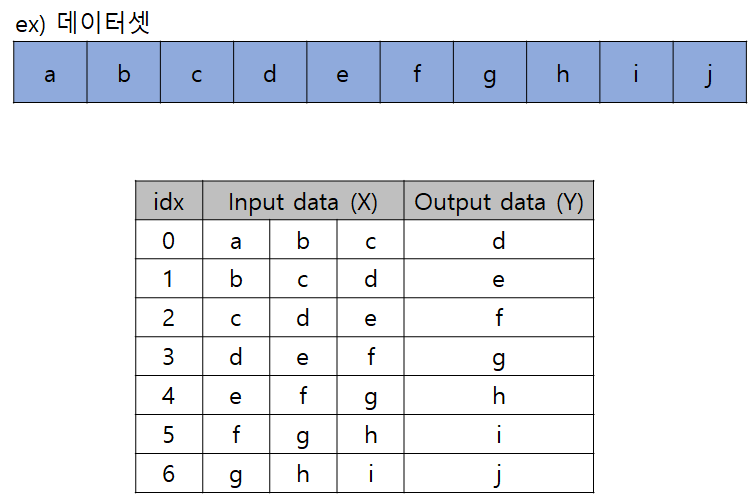

In [8]:
def seq2dataset(seq,window,horizon):
    X=[]; Y=[]
    for i in range(len(seq)-(window+horizon)+1):
        x=seq[i:(i+window)]
        y=(seq[i+window+horizon-1])
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

In [9]:
# 윈도우 w와 수평선 h

w = 100   # 윈도우는 이전 요소 몇 개를 볼 것인지
h = 10    # 수평선은 얼마나 먼 미래를 예측할 것인지

In [10]:
X, Y = seq2dataset(seq, w, h)

In [11]:
print(X.shape, Y.shape)

(2505, 100, 5) (2505, 5)


In [28]:
print(X[0], Y[0])

[[3.18199066e-03 2.52605283e-03 3.32614195e-03 3.18589848e-03
  3.55568085e-03]
 [3.18421666e-03 2.45903451e-03 3.34233013e-03 3.13574788e-03
  1.48326158e-03]
 [3.18169386e-03 2.46368654e-03 3.33794268e-03 3.21067703e-03
  3.26371389e-03]
 [3.21122544e-03 2.47168222e-03 3.37122679e-03 3.22343724e-03
  3.35812190e-03]
 [3.22398783e-03 2.47371748e-03 3.35609765e-03 3.18515661e-03
  3.88222656e-03]
 [3.18570066e-03 2.41542172e-03 3.14096125e-03 3.01497099e-03
  4.27006434e-03]
 [3.01548597e-03 2.39943036e-03 3.20117523e-03 3.15963619e-03
  4.31391354e-03]
 [3.16017588e-03 2.38634652e-03 3.31192055e-03 3.16141668e-03
  1.11577864e-03]
 [3.16195668e-03 2.39376070e-03 3.33990947e-03 3.18812410e-03
  1.18306458e-03]
 [3.18866866e-03 2.39303382e-03 3.21040401e-03 3.00621689e-03
  4.73274504e-03]
 [3.00673038e-03 2.21901878e-03 2.89828980e-03 2.79671202e-03
  9.55092856e-03]
 [2.79718972e-03 2.04834740e-03 2.94761081e-03 2.76169562e-03
  2.98361775e-03]
 [2.76216734e-03 2.20375431e-03 2.835201

## 데이터셋 split

In [13]:
split=int(len(X)*0.7)

In [14]:
x_train=X[0:split]
y_train=Y[0:split]
x_test=X[split:]
y_test=Y[split:]

## Modeling

In [108]:
model = Sequential()
model.add(LSTM(units=16,activation='tanh',input_shape=x_train[0].shape))
model.add(Dense(16, activation="relu"))
model.add(Dense(5))

In [109]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [110]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [111]:
hist=model.fit(x_train,y_train,epochs=200,batch_size=16,validation_data=(x_test,y_test),callbacks=[checkpoint, earlystopping], verbose=1)

Epoch 1/200
109/110 [============================>.] - ETA: 0s - loss: 8.7165e-04 - mse: 0.0017
Epoch 1: val_loss improved from inf to 0.03985, saving model to tmp\ckeckpointer.ckpt
110/110 [==============================] - 4s 25ms/step - loss: 8.7021e-04 - mse: 0.0017 - val_loss: 0.0398 - val_mse: 0.0797
Epoch 2/200
108/110 [============================>.] - ETA: 0s - loss: 3.4898e-04 - mse: 6.9795e-04
Epoch 2: val_loss improved from 0.03985 to 0.03949, saving model to tmp\ckeckpointer.ckpt
110/110 [==============================] - 3s 23ms/step - loss: 3.4649e-04 - mse: 6.9299e-04 - val_loss: 0.0395 - val_mse: 0.0790
Epoch 3/200
110/110 [==============================] - ETA: 0s - loss: 2.9525e-04 - mse: 5.9049e-04
Epoch 3: val_loss improved from 0.03949 to 0.03921, saving model to tmp\ckeckpointer.ckpt
110/110 [==============================] - 3s 24ms/step - loss: 2.9525e-04 - mse: 5.9049e-04 - val_loss: 0.0392 - val_mse: 0.0784
Epoch 4/200
108/110 [============================>.]

## 모델 평가

In [112]:
ev=model.evaluate(x_test, y_test, verbose=1)

24/24 [==============================] - 0s 7ms/step - loss: 0.0339 - mse: 0.0678   


In [113]:
print("손실 함수:", ev[0], "MSE", ev[1])

손실 함수: 0.03391161933541298 MSE 0.06782323867082596


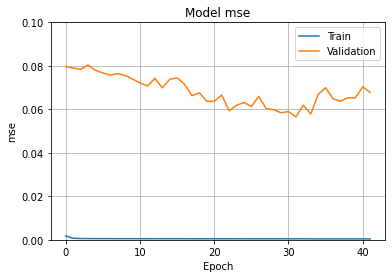

In [123]:
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('Model mse')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.ylim([0,0.1])
plt.legend(['Train','Validation'], loc='best')
plt.grid()
plt.show()

In [124]:
pred = model.predict(x_test)

In [125]:
pred.shape

(752, 5)

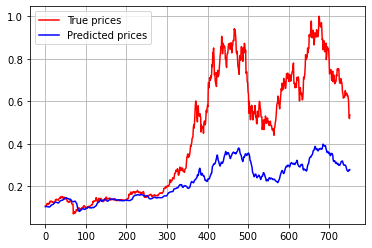

In [126]:
#'Open'

x_range=range(len(y_test))
plt.plot(x_range,y_test[x_range][:,0], color='red')
plt.plot(x_range,pred[x_range][:,0], color='blue')
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

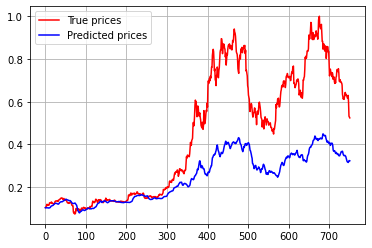

In [127]:
#'High

x_range=range(len(y_test))
plt.plot(x_range,y_test[x_range][:,1], color='red')
plt.plot(x_range,pred[x_range][:,1], color='blue')
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

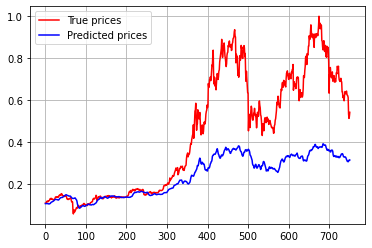

In [128]:
#'Low'

x_range=range(len(y_test))
plt.plot(x_range,y_test[x_range][:,2], color='red')
plt.plot(x_range,pred[x_range][:,2], color='blue')
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

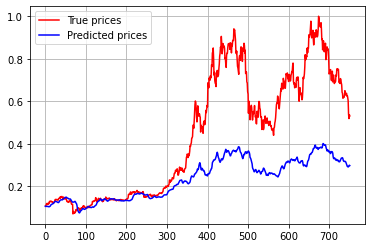

In [129]:
#'Close'

x_range=range(len(y_test))
plt.plot(x_range,y_test[x_range][:,3], color='red')
plt.plot(x_range,pred[x_range][:,3], color='blue')
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

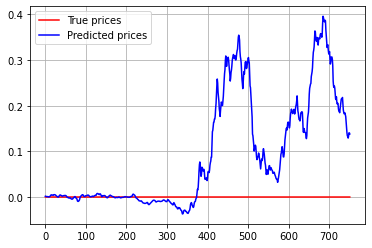

In [130]:
#'Volume'

x_range=range(len(y_test))
plt.plot(x_range,y_test[x_range][:,4], color='red')
plt.plot(x_range,pred[x_range][:,4], color='blue')
plt.legend(['True prices','Predicted prices'], loc='best')
plt.grid()
plt.show()

In [131]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 16)                1408      
                                                                 
 dense_8 (Dense)             (None, 16)                272       
                                                                 
 dense_9 (Dense)             (None, 5)                 85        
                                                                 
Total params: 1,765
Trainable params: 1,765
Non-trainable params: 0
_________________________________________________________________


# 3. 다중 채널 비트코인 가격 예측 (many to one)

## 데이터 전처리

In [97]:
data.columns = ['Open','High','Low','Close','Volume']

In [98]:
# MinMax 스케일링


scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(data[scale_cols])
scaled

array([[3.18199066e-03, 2.52605283e-03, 3.32614195e-03, 3.18589848e-03,
        3.55568085e-03],
       [3.18421666e-03, 2.45903451e-03, 3.34233013e-03, 3.13574788e-03,
        1.48326158e-03],
       [3.18169386e-03, 2.46368654e-03, 3.33794268e-03, 3.21067703e-03,
        3.26371389e-03],
       ...,
       [5.38474529e-01, 5.32267068e-01, 5.12085159e-01, 5.18259121e-01,
        5.83995879e-06],
       [5.18253856e-01, 5.28610717e-01, 5.21534670e-01, 5.36101310e-01,
        3.28059996e-06],
       [5.35726757e-01, 5.24284183e-01, 5.41094382e-01, 5.30519756e-01,
        4.88827305e-08]])

In [99]:
# 전처리 완료된 최종 데이터 프레임 df 생성

df = pd.DataFrame(scaled, columns=scale_cols)

In [100]:
# data를 numpy형태로 전환

seq=df.to_numpy()

## 윈도우 크기와 수평선 크기

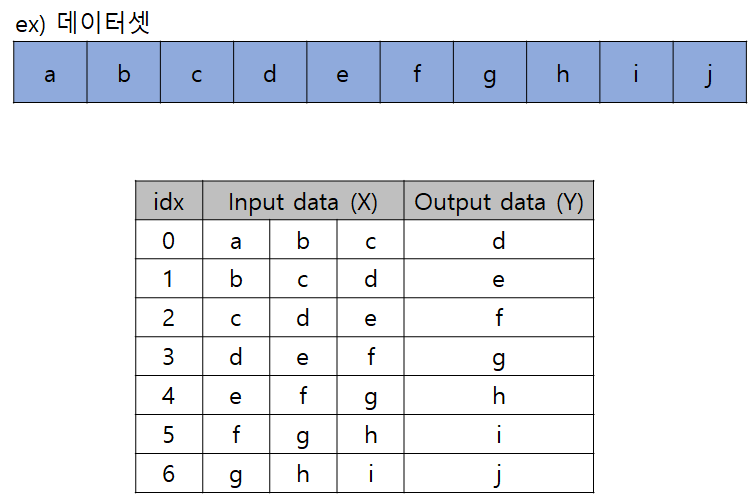

In [101]:
def seq2dataset(seq,window,horizon):
    X=[]; Y=[]
    for i in range(len(seq)-(window+horizon)+1):
        x=seq[i:(i+window)]
        y=(seq[i+window+horizon-1])   # Close(종가)만 y값으로 할당
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

In [102]:
# 윈도우 w와 수평선 h

w = 3   # 윈도우는 이전 요소 몇 개를 볼 것인지
h = 1    # 수평선은 얼마나 먼 미래를 예측할 것인지

In [103]:
X, Y = seq2dataset(seq, w, h)

In [104]:
print(X.shape, Y.shape)

(2611, 3, 5) (2611, 5)


In [35]:
print(X[0], Y[0])

[[0.00318199 0.00252605 0.00332614 0.0031859  0.00355568]
 [0.00318422 0.00245903 0.00334233 0.00313575 0.00148326]
 [0.00318169 0.00246369 0.00333794 0.00321068 0.00326371]] 0.0032234372449812306


## 데이터셋 split

In [36]:
split=int(len(X)*0.7)

In [132]:
x_train=X[0:split]
y_train=Y[0:split]
x_test=X[split:]
y_test=Y[split:]

## Modeling

In [133]:
model = Sequential()
model.add(LSTM(units=16,activation='tanh',input_shape=x_train[0].shape))
model.add(Dense(16, activation="relu"))
model.add(Dense(1))

In [134]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [135]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [138]:
hist=model.fit(x_train,y_train[:,3],epochs=200,batch_size=16,validation_data=(x_test,y_test[:,3]),callbacks=[checkpoint, earlystopping], verbose=1)   
# y_train과 y_test에서 [:,3]로 인덱싱하는 이유는, 종가만을 y_val로 추출하기 위해서임
# x_train 데이터셋 구성 자체가, 한 단위씩(ex 1일, 1시간, 1분) 밀리면서 구성된 데이터셋으로, for문을 돌려가며 예측할 필요 없음

Epoch 1/200
102/115 [=========================>....] - ETA: 0s - loss: 1.4024e-05 - mse: 2.8048e-05
Epoch 1: val_loss did not improve from 0.00761
115/115 [==============================] - 1s 6ms/step - loss: 1.5471e-05 - mse: 3.0943e-05 - val_loss: 0.0095 - val_mse: 0.0191
Epoch 2/200
103/115 [=========================>....] - ETA: 0s - loss: 1.7151e-05 - mse: 3.4302e-05
Epoch 2: val_loss did not improve from 0.00761
115/115 [==============================] - 0s 3ms/step - loss: 1.6565e-05 - mse: 3.3130e-05 - val_loss: 0.0091 - val_mse: 0.0181
Epoch 3/200
103/115 [=========================>....] - ETA: 0s - loss: 1.6194e-05 - mse: 3.2387e-05
Epoch 3: val_loss did not improve from 0.00761
115/115 [==============================] - 0s 3ms/step - loss: 1.6013e-05 - mse: 3.2025e-05 - val_loss: 0.0091 - val_mse: 0.0182
Epoch 4/200
104/115 [==========================>...] - ETA: 0s - loss: 1.5659e-05 - mse: 3.1317e-05
Epoch 4: val_loss did not improve from 0.00761
115/115 [================

# 3-1. 상승장 다중채널 모델

In [61]:
with open("../btc_usd_1d_profit.pkl","rb") as fr:
    data = pickle.load(fr)
print(data)
data = data[['Open','High','Low','Close','Volume']]

                Open      High       Low     Close        Volume   Datetime
Datetime                                                                   
2017-01-01    966.34   1005.00    960.53    998.80  6.579904e+06 2017-01-01
2017-01-02    997.75   1032.00    990.01   1014.10  8.190255e+06 2017-01-02
2017-01-03   1011.44   1039.00    999.99   1036.99  8.955193e+06 2017-01-03
2017-01-04   1035.51   1139.89   1028.56   1122.56  2.325716e+07 2017-01-04
2017-01-05   1114.38   1136.72    885.41    994.02  3.503690e+07 2017-01-05
...              ...       ...       ...       ...           ...        ...
2022-05-12  29077.90  30257.00  26631.00  29020.70  9.644756e+05 2022-05-12
2022-05-13  29020.80  31072.60  28730.40  29274.30  5.076201e+05 2022-05-13
2022-05-14  29274.20  30352.20  28602.30  30079.80  3.157569e+05 2022-05-14
2022-05-15  30079.50  31462.00  29448.00  31324.40  3.367731e+05 2022-05-15
2022-05-16  31324.30  31327.40  29280.00  29851.50  1.971161e+05 2022-05-16

[1962 rows 

In [62]:
data

,Open,High,Low,Close,Volume
Datetime,,,,,
2017-01-01,966.34,1005.00,960.53,998.80,6.579904e+06
2017-01-02,997.75,1032.00,990.01,1014.10,8.190255e+06
2017-01-03,1011.44,1039.00,999.99,1036.99,8.955193e+06
2017-01-04,1035.51,1139.89,1028.56,1122.56,2.325716e+07
2017-01-05,1114.38,1136.72,885.41,994.02,3.503690e+07
...,...,...,...,...,...
2022-05-12,29077.90,30257.00,26631.00,29020.70,9.644756e+05
2022-05-13,29020.80,31072.60,28730.40,29274.30,5.076201e+05
2022-05-14,29274.20,30352.20,28602.30,30079.80,3.157569e+05


In [63]:
# MinMax 스케일링


scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(data[scale_cols])
scaled

array([[2.81029505e-03, 2.66293909e-03, 3.19380580e-03, 3.14496634e-03,
        8.51950729e-03],
       [3.28072442e-03, 3.05896969e-03, 3.64389134e-03, 3.37411051e-03,
        1.06045641e-02],
       [3.48576034e-03, 3.16164429e-03, 3.79626087e-03, 3.71692817e-03,
        1.15949943e-02],
       ...,
       [4.26778739e-01, 4.33121799e-01, 4.25214195e-01, 4.38683640e-01,
        4.08788186e-04],
       [4.38839763e-01, 4.49400124e-01, 4.38125910e-01, 4.57323695e-01,
        4.35999689e-04],
       [4.57483204e-01, 4.47425838e-01, 4.35560972e-01, 4.35264450e-01,
        2.55173936e-04]])

In [64]:
# 전처리 완료된 최종 데이터 프레임 df 생성

df = pd.DataFrame(scaled, columns=scale_cols)

In [65]:
# data를 numpy형태로 전환

seq=df.to_numpy()

## 윈도우 크기와 수평선 크기

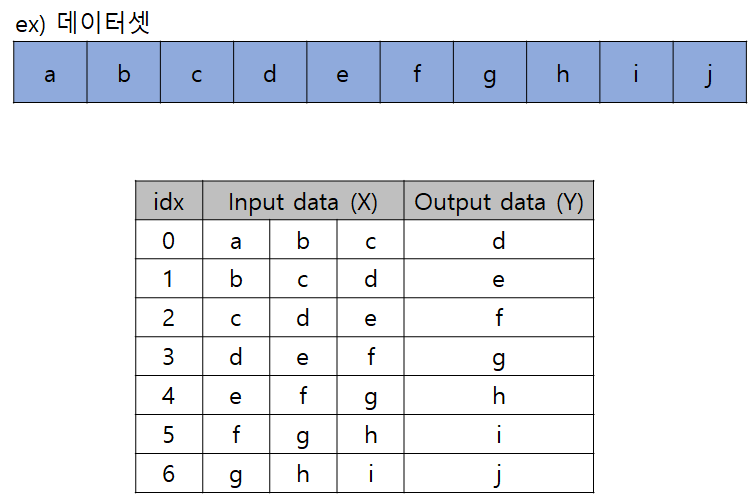

In [66]:
def seq2dataset(seq,window,horizon):
    X=[]; Y=[]
    for i in range(0, len(seq)-(window+horizon)+1, 5):
        x=seq[i:(i+window)]
        y=(seq[i+window+horizon-1])   # Close(종가)만 y값으로 할당
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

In [67]:
# 윈도우 w와 수평선 h

w = 10   # 윈도우는 이전 요소 몇 개를 볼 것인지
h = 1    # 수평선은 얼마나 먼 미래를 예측할 것인지

In [68]:
X, Y = seq2dataset(seq, w, h)

In [69]:
print(X.shape, Y.shape)

(391, 10, 5) (391, 5)


In [70]:
print(X[0], Y[0])

[[0.0028103  0.00266294 0.00319381 0.00314497 0.00851951]
 [0.00328072 0.00305897 0.00364389 0.00337411 0.01060456]
 [0.00348576 0.00316164 0.00379626 0.00371693 0.01159499]
 [0.00384626 0.00464148 0.00423245 0.00499849 0.03011296]
 [0.0050275  0.00459498 0.00204691 0.00307338 0.04536518]
 [0.00338526 0.00298548 0.00182691 0.00153886 0.03267873]
 [0.00172715 0.00121083 0.0009304  0.00162243 0.02204545]
 [0.00190957 0.00173608 0.00198416 0.00175767 0.01047275]
 [0.00196349 0.00131159 0.00188798 0.00166511 0.01001271]
 [0.00175816 0.00130573 0.00210798 0.00178448 0.0092678 ]] [1.89235120e-03 1.39270761e-03 5.58790058e-05 0.00000000e+00
 3.76927439e-02]


## 데이터셋 split

In [71]:
split=int(len(X)*0.7)

In [72]:
x_train=X[0:split]
y_train=Y[0:split]
x_test=X[split:]
y_test=Y[split:]

In [73]:
# LSTM 모델 구축
model = Sequential()
model.add(LSTM(units=256,activation='tanh',input_shape=x_train[0].shape))
model.add(Dropout(0.2))
model.add(Dense(1))
            
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용한다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
            
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춘다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

model.fit(x_train,y_train[:,3],epochs=100,batch_size=16,validation_split=0.3,callbacks=[earlystopping], verbose=1)

Epoch 1/100
12/12 [==============================] - 4s 78ms/step - loss: 0.0016 - mse: 0.0032 - val_loss: 1.1299e-04 - val_mse: 2.2599e-04
Epoch 2/100
12/12 [==============================] - 0s 22ms/step - loss: 2.3524e-04 - mse: 4.7049e-04 - val_loss: 4.1109e-04 - val_mse: 8.2217e-04
Epoch 3/100
12/12 [==============================] - 0s 21ms/step - loss: 1.3497e-04 - mse: 2.6994e-04 - val_loss: 4.3088e-05 - val_mse: 8.6176e-05
Epoch 4/100
12/12 [==============================] - 0s 25ms/step - loss: 1.3639e-04 - mse: 2.7278e-04 - val_loss: 7.2791e-05 - val_mse: 1.4558e-04
Epoch 5/100
12/12 [==============================] - 0s 22ms/step - loss: 1.0797e-04 - mse: 2.1594e-04 - val_loss: 2.3205e-05 - val_mse: 4.6410e-05
Epoch 6/100
12/12 [==============================] - 0s 23ms/step - loss: 1.2008e-04 - mse: 2.4017e-04 - val_loss: 2.2758e-05 - val_mse: 4.5517e-05
Epoch 7/100
12/12 [==============================] - 0s 25ms/step - loss: 1.1934e-04 - mse: 2.3867e-04 - val_loss: 4.611

In [74]:
def plot_result(df):
    plt.figure(figsize=(20, 8))
    plt.plot(df.index, df['Close'].values, color='b', label='real close')
    plt.plot(df.index, df['prediction_close'].values , color='r', label='prediction close')
    plt.legend()
    plt.grid(True)
    plt.show()

In [75]:
pred = model.predict(x_test)

In [76]:
result_df = pd.DataFrame()
result_df['Close'] = y_test[:,3]
result_df['prediction_close'] = pred

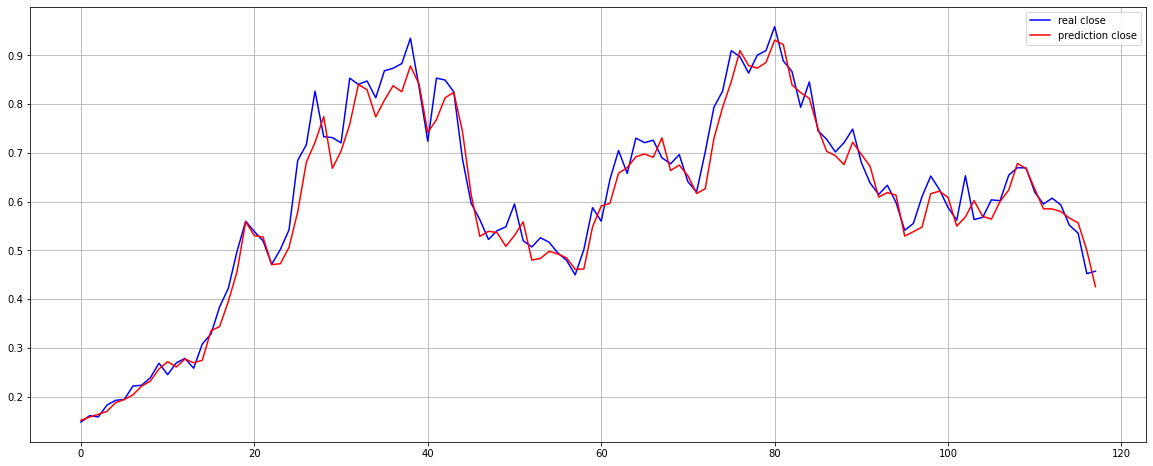

In [77]:
plot_result(result_df)

In [78]:
from sklearn.metrics import mean_squared_error
y=result_df['Close']
y_pred=result_df['prediction_close']
RMSE = mean_squared_error(y, y_pred)**0.5
print(RMSE)

0.03547939107744392


# 3-2. 하락장 다중채널 모델

In [79]:
with open("../btc_usd_1d_loss.pkl","rb") as fr:
    data = pickle.load(fr)
print(data)
data = data[['Open','High','Low','Close','Volume']]

                Open      High       Low     Close        Volume   Datetime
Datetime                                                                   
2017-01-01    966.34   1005.00    960.53    998.80  6.579904e+06 2017-01-01
2017-01-02    997.75   1032.00    990.01   1014.10  8.190255e+06 2017-01-02
2017-01-03   1011.44   1039.00    999.99   1036.99  8.955193e+06 2017-01-03
2017-01-04   1035.51   1139.89   1028.56   1122.56  2.325716e+07 2017-01-04
2017-01-05   1114.38   1136.72    885.41    994.02  3.503690e+07 2017-01-05
...              ...       ...       ...       ...           ...        ...
2022-05-12  29077.90  30257.00  26631.00  29020.70  9.644756e+05 2022-05-12
2022-05-13  29020.80  31072.60  28730.40  29274.30  5.076201e+05 2022-05-13
2022-05-14  29274.20  30352.20  28602.30  30079.80  3.157569e+05 2022-05-14
2022-05-15  30079.50  31462.00  29448.00  31324.40  3.367731e+05 2022-05-15
2022-05-16  31324.30  31327.40  29280.00  29851.50  1.971161e+05 2022-05-16

[1962 rows 

In [80]:
data

,Open,High,Low,Close,Volume
Datetime,,,,,
2017-01-01,966.34,1005.00,960.53,998.80,6.579904e+06
2017-01-02,997.75,1032.00,990.01,1014.10,8.190255e+06
2017-01-03,1011.44,1039.00,999.99,1036.99,8.955193e+06
2017-01-04,1035.51,1139.89,1028.56,1122.56,2.325716e+07
2017-01-05,1114.38,1136.72,885.41,994.02,3.503690e+07
...,...,...,...,...,...
2022-05-12,29077.90,30257.00,26631.00,29020.70,9.644756e+05
2022-05-13,29020.80,31072.60,28730.40,29274.30,5.076201e+05
2022-05-14,29274.20,30352.20,28602.30,30079.80,3.157569e+05


In [81]:
# MinMax 스케일링


scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(data[scale_cols])
scaled

array([[2.81029505e-03, 2.66293909e-03, 3.19380580e-03, 3.14496634e-03,
        8.51950729e-03],
       [3.28072442e-03, 3.05896969e-03, 3.64389134e-03, 3.37411051e-03,
        1.06045641e-02],
       [3.48576034e-03, 3.16164429e-03, 3.79626087e-03, 3.71692817e-03,
        1.15949943e-02],
       ...,
       [4.26778739e-01, 4.33121799e-01, 4.25214195e-01, 4.38683640e-01,
        4.08788186e-04],
       [4.38839763e-01, 4.49400124e-01, 4.38125910e-01, 4.57323695e-01,
        4.35999689e-04],
       [4.57483204e-01, 4.47425838e-01, 4.35560972e-01, 4.35264450e-01,
        2.55173936e-04]])

In [82]:
# 전처리 완료된 최종 데이터 프레임 df 생성

df = pd.DataFrame(scaled, columns=scale_cols)

In [83]:
# data를 numpy형태로 전환

seq=df.to_numpy()

## 윈도우 크기와 수평선 크기

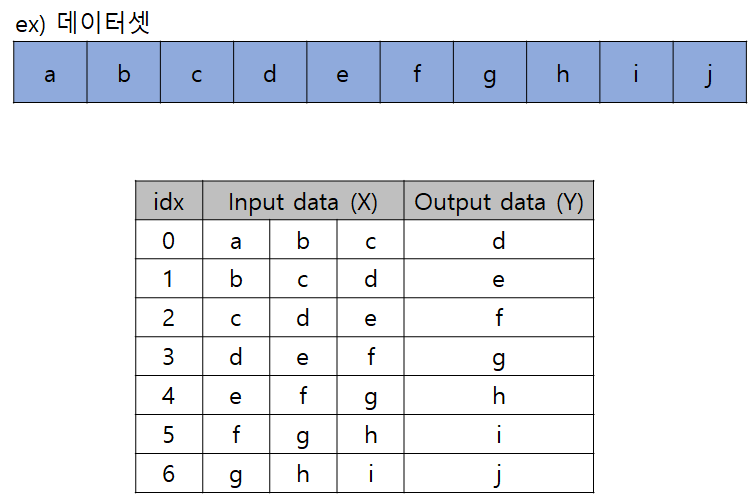

In [84]:
def seq2dataset(seq,window,horizon):
    X=[]; Y=[]
    for i in range(0, len(seq)-(window+horizon)+1, 5):
        x=seq[i:(i+window)]
        y=(seq[i+window+horizon-1])   # Close(종가)만 y값으로 할당
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

In [85]:
# 윈도우 w와 수평선 h

w = 10   # 윈도우는 이전 요소 몇 개를 볼 것인지
h = 1    # 수평선은 얼마나 먼 미래를 예측할 것인지

In [86]:
X, Y = seq2dataset(seq, w, h)

In [87]:
print(X.shape, Y.shape)

(391, 10, 5) (391, 5)


In [88]:
print(X[0], Y[0])

[[0.0028103  0.00266294 0.00319381 0.00314497 0.00851951]
 [0.00328072 0.00305897 0.00364389 0.00337411 0.01060456]
 [0.00348576 0.00316164 0.00379626 0.00371693 0.01159499]
 [0.00384626 0.00464148 0.00423245 0.00499849 0.03011296]
 [0.0050275  0.00459498 0.00204691 0.00307338 0.04536518]
 [0.00338526 0.00298548 0.00182691 0.00153886 0.03267873]
 [0.00172715 0.00121083 0.0009304  0.00162243 0.02204545]
 [0.00190957 0.00173608 0.00198416 0.00175767 0.01047275]
 [0.00196349 0.00131159 0.00188798 0.00166511 0.01001271]
 [0.00175816 0.00130573 0.00210798 0.00178448 0.0092678 ]] [1.89235120e-03 1.39270761e-03 5.58790058e-05 0.00000000e+00
 3.76927439e-02]


## 데이터셋 split

In [89]:
split=int(len(X)*0.7)

In [90]:
x_train=X[0:split]
y_train=Y[0:split]
x_test=X[split:]
y_test=Y[split:]

In [91]:
# LSTM 모델 구축
model = Sequential()
model.add(LSTM(units=256,activation='tanh',input_shape=x_train[0].shape))
model.add(Dropout(0.2))
model.add(Dense(1))
            
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용한다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
            
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춘다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

model.fit(x_train,y_train[:,3],epochs=100,batch_size=16,validation_split=0.3,callbacks=[earlystopping], verbose=1)

Epoch 1/100
12/12 [==============================] - 3s 82ms/step - loss: 0.0010 - mse: 0.0021 - val_loss: 8.3167e-05 - val_mse: 1.6633e-04
Epoch 2/100
12/12 [==============================] - 0s 23ms/step - loss: 2.4346e-04 - mse: 4.8692e-04 - val_loss: 1.1482e-04 - val_mse: 2.2963e-04
Epoch 3/100
12/12 [==============================] - 0s 26ms/step - loss: 1.3347e-04 - mse: 2.6695e-04 - val_loss: 3.4252e-05 - val_mse: 6.8504e-05
Epoch 4/100
12/12 [==============================] - 0s 29ms/step - loss: 1.1924e-04 - mse: 2.3847e-04 - val_loss: 2.5868e-05 - val_mse: 5.1737e-05
Epoch 5/100
12/12 [==============================] - 0s 22ms/step - loss: 1.0203e-04 - mse: 2.0406e-04 - val_loss: 2.8972e-05 - val_mse: 5.7943e-05
Epoch 6/100
12/12 [==============================] - 0s 20ms/step - loss: 1.0437e-04 - mse: 2.0875e-04 - val_loss: 3.5376e-05 - val_mse: 7.0751e-05
Epoch 7/100
12/12 [==============================] - 0s 25ms/step - loss: 1.0171e-04 - mse: 2.0341e-04 - val_loss: 2.268

In [92]:
def plot_result(df):
    plt.figure(figsize=(20, 8))
    plt.plot(df.index, df['Close'].values, color='b', label='real close')
    plt.plot(df.index, df['prediction_close'].values , color='r', label='prediction close')
    plt.legend()
    plt.grid(True)
    plt.show()

In [93]:
pred = model.predict(x_test)

In [94]:
result_df = pd.DataFrame()
result_df['Close'] = y_test[:,3]
result_df['prediction_close'] = pred

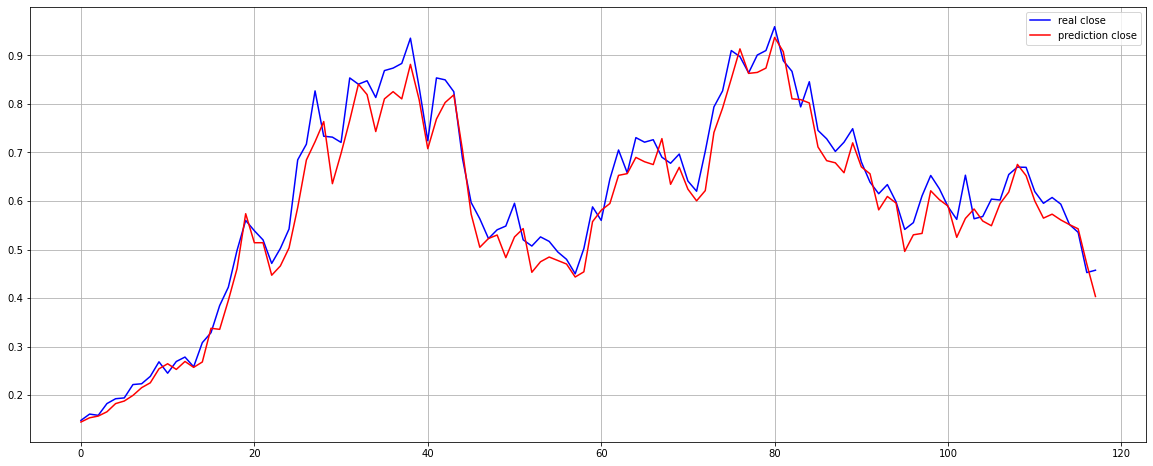

In [95]:
plot_result(result_df)

In [96]:
from sklearn.metrics import mean_squared_error
y=result_df['Close']
y_pred=result_df['prediction_close']
RMSE = mean_squared_error(y, y_pred)**0.5
print(RMSE)

0.039955858496603554


# 4. 수익률 확인
### 여기서 확인한 수익률은 3. 다중 채널 비트코인(many to one)에 해당하는 내용입니다.

In [23]:
warnings.simplefilter('ignore', ConvergenceWarning)
print("\nStatsmodels' ConvergenceWarning is ignored")


Statsmodels' ConvergenceWarning is ignored


In [24]:
def analysis_return(test_df):
    # ror: 일일 수익률
    # trading_rate: 거래 확률
    # success_rate: 거래 성공 확률
    # pnl_rate: 손익비
    # mdd: 최대 손실 낙폭
    # cr: 누적 수익률

    df = test_df.copy()
    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    mdd = df['mdd'].max()
    cr = df['cr'].iloc[-1]

    return_dict = {}
    return_dict['trade_rate'] = f'{trade_rate * 100: .2f}%'
    return_dict['success_rate'] = f'{success_rate * 100: .2f}%'
    return_dict['pnl_rate'] = f'{pnl_rate: .2f}'
    return_dict['mdd'] = f'{mdd: .2f}%'
    return_dict['cr'] = f'{(cr - 1) * 100: .2f}%'

    return return_dict

def backtest_ma(test_df):
    df = test_df.copy()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    
    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    df['pnl_rate'] = f'{pnl_rate: .2f}'

    return df


def backtest_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    
    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    df['pnl_rate'] = f'{pnl_rate: .2f}'

    return df


def backtest_rsi(test_df):
    df = test_df.copy()
    df['rate'] = 1
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi
    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rsi_shift_1'] > 40), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, df['Close'] / df['Open'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    
    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    df['pnl_rate'] = f'{pnl_rate: .2f}'

    return df


def backtest_ma_and_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()

    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 10

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0), 1, 0)
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    
    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    df['pnl_rate'] = f'{pnl_rate: .2f}'

    return df


def backtest_ma_and_rsi(test_df):
    df = test_df.copy()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    df['pnl_rate'] = f'{pnl_rate: .2f}'

    return df


def backtest_noise_and_rsi(test_df):
    df = test_df.copy()
    noise_ma = 30
    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['rate'] = 0
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 5

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    df['pnl_rate'] = f'{pnl_rate: .2f}'

    return df


def backtest_ma_and_rsi_and_noise(test_df):
    noise_ma = 30
    df = test_df.copy()
    df['up'] = np.where(df['Close'].diff(1) > 0, df['Close'].diff(1), 0)
    df['down'] = np.where(df['Close'].diff(1) < 0, df['Close'].diff(1) * (-1), 0)
    df['au'] = df['up'].rolling(window=14, min_periods=14).mean()
    df['ad'] = df['down'].rolling(window=14, min_periods=14).mean()
    df['rsi'] = df['au'].div(df['ad'] + df['au']) * 100
    df['rsi_shift_1'] = df['rsi'].shift(1) # 하루 전의 rsi

    df['noise'] = 1 - abs(df['Open'] - df['Close']) / ((df['High']) * (1.0000001) - df['Low'])
    df['noise'] = df['noise'].shift(1)
    df['noise_ma'] = df['noise'].rolling(window=noise_ma).mean()
    df['ma5'] = df['Open'].rolling(window=5).mean()
    df['ma10'] = df['Open'].rolling(window=10).mean()
    df['ma20'] = df['Open'].rolling(window=20).mean()
    df['ma50'] = df['Open'].rolling(window=50).mean()
    df['ma100'] = df['Open'].rolling(window=100).mean()

    df['rate'] = 0
    df['rate'] = np.where(df['ma5'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma10'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma20'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma50'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['ma100'] < df['Open'], df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.3, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.4, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.5, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.6, df['rate'] + 1, df['rate'])
    df['rate'] = np.where(df['noise_ma'] < 0.7, df['rate'] + 1, df['rate'])
    df['rate'] = df['rate'] / 10

    df['trade'] = np.where((df['Open'] < df['prediction_close']) & (df['rate'] > 0) & (df['rsi_shift_1'] > 40), 1, 0)  # rsi가 40이상일 경우에만 거래 진행
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100

    df['success'] = np.where((df['ror'] > 1) & (df['trade'] == 1), 1, 0)
    df['fail'] = np.where((df['ror'] < 1) & (df['trade'] == 1), 1, 0)
    df['success_ror'] = np.where(df['success'], (df['ror'] - 1) * 100, 0)
    df['fail_ror'] = np.where(df['fail'], (1 - df['ror']) * 100, 0)

    trade_rate = df['trade'].sum() / len(df)
    success_rate = df['success'].sum() / df['trade'].sum()
    pnl_rate = df['success_ror'].sum() / df['fail_ror'].sum()
    df['pnl_rate'] = f'{pnl_rate: .2f}'

    return df

def plot_result(df):
    plt.figure(figsize=(20, 8))
    plt.plot(df.index, df['Close'].values, color='b', label='real close')
    plt.plot(df.index, df['prediction_close'].values , color='r', label='prediction close')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_return(df):
    plt.figure(figsize=(20, 8))
    plt.plot(df.index, df['cr'].values , color='r', label='return')
    plt.legend()
    plt.title(
        f"mdd: {round(df['mdd'].max(), 2)}\nreturn_rate: {round(df['cr'].iloc[-1] * 100 - 100, 2)}%")
    plt.grid(True)
    plt.show()

In [25]:
def get_result_loss_1(test_df):
    df = test_df.copy()
    df = df[(df.index >= "2021-05-10") & (df.index <= "2021-07-21")]
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return analysis_return(df)



def get_result_loss_2(test_df):
    df = test_df.copy()
    df = df[(df.index >= "2021-11-18") & (df.index <= "2022-02-06")]
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return analysis_return(df)



def get_result_profit_1(test_df):
    df = test_df.copy()
    df = df[(df.index >= "2019-02-17") & (df.index <= "2019-07-15")]
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return analysis_return(df)


def get_result_profit_2(test_df):
    df = test_df.copy()
    df = df[(df.index >= "2020-10-08") & (df.index <= "2021-04-17")]
    df['ror'] = np.where(df['trade'] == 1, 1 + (df['Close'] / df['Open'] - 1) * df['rate'], 1)
    df['cr'] = df['ror'].cumprod()
    df['mdd'] = (df['cr'].cummax() - df['cr']) / df['cr'].cummax() * 100
    return analysis_return(df)

In [6]:
def batch(iterable, batch_size, pt):
    """
    batch row 생성 이터레이터
    Args:
        iterable: iterable datastructure
        batch_size:
        pt: prediction term 예측 기간
    Returns:
        yield: batch row
    """

    l = len(iterable)
    for idx, ndx in tqdm(enumerate(range(0, l, pt))):
        yield idx, iterable[ndx: min(ndx + batch_size, l)]

        
def seq2dataset(df,window,horizon):
    X=[]; Y=[]
    
    x_val, y_val = df.drop('Close',axis=1,inplace=False),df['Close']
    x_val = x_val.to_numpy()
    y_val = y_val.to_numpy()
    
    for i in range(0, len(df)-(window+horizon)+1, 5):
        x=x_val[i:(i+window)]
        y=y_val[i+window+horizon-1]
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

        
def backtest_lstm_1d(test_df: pd.DataFrame, ft: int, pt: int, plot=True) -> pd.DataFrame:
    """

    Args:
        test_df: 1일 봉 데이터
        ft: fitting term 피팅 시킬 기간
        pt: prediction term 예측 기간
        arima_params:
    Returns:
        df: 예측 값이 열로 포함된 DataFrame
    """
    df = test_df.copy()
    df = df.drop('Datetime',axis=1,inplace=False)
    
    scaler = MinMaxScaler()

    # 스케일 후 columns
    df = pd.DataFrame(scaler.fit_transform(df[:]),columns=df.columns, index=list(df.index.values))
    
    batch_size = ft + pt
    total_loop = int(len(df) / pt) - 1
    result_columns = list(df.columns)
    result_columns.append("prediction_close")

    result_df = pd.DataFrame(columns=result_columns)

    try:
        for idx, batch_df in batch(df, batch_size, pt):
            # 윈도우 w와 수평선 h

            w = 10   # 윈도우는 이전 요소 몇 개를 볼 것인지
            h = 1    # 수평선은 얼마나 먼 미래를 예측할 것인지
            
            train, test = batch_df[:ft-1], batch_df[ft-w:ft]
            X_train, y_train = seq2dataset(train, w, h)
            
            
            #X_train = X_train.reshape((len(X_train), 1, 4))
            #y_train = y_train.reshape((len(y_train), 1, 1))
            
            X_test, y_test = test.drop('Close',axis=1,inplace=False),test['Close']
            X_test = X_test.to_numpy()
            y_test = y_test.to_numpy()
            
            X_test = X_test.reshape(pt, w, 4)
            y_test = y_test.reshape(pt, w, 1)

            # LSTM 모델 구축
            model = Sequential()
            model.add(LSTM(units=256,activation='tanh',input_shape=X_train[0].shape))
            model.add(Dropout(0.2))
            model.add(Dense(1))
            
            # Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용한다.
            loss = Huber()
            optimizer = Adam(0.0005)
            model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
            
            # earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춘다.
            earlystopping = EarlyStopping(monitor='val_loss', patience=10)
            # val_loss 기준 체크포인터도 생성한다.
                        
            model.fit(X_train,y_train,epochs=100,batch_size=16,validation_split=0.3,callbacks=[earlystopping], verbose=0)  
            
            # 예측
            pred = model.predict(X_test)
            
            if len(pred) ==0:
                break
            row = batch_df.iloc[[-1]]
            row['prediction_close'] = pred
            row['batch_open'] = batch_df.iloc[ft].Open
            result_df = pd.concat([result_df, row], axis=0)

    except IndexError:
        pass
    result_df['trade'] = np.where(result_df['batch_open'] < result_df['prediction_close'], 1, 0)
    result_df['ror'] = np.where(result_df['trade'] == 1, result_df['Close'] / result_df['batch_open'], 1)
    result_df['cr'] = result_df['ror'].cumprod()
    result_df['mdd'] = (result_df['cr'].cummax() - result_df['cr']) / result_df['cr'].cummax() * 100

    if plot:
        plot_result(result_df)
        plot_return(result_df)

    return result_df

In [7]:
with open("../btc_usd_1d.pkl", "rb") as f:
    df=pickle.load(f)
    #df=df.reset_index()
    #df.rename({'ot':'Date'},axis=1,inplace=True)

4it [00:45, 11.83s/it]

5it [00:53, 10.47s/it]

1862it [3:49:30,  7.40s/it]


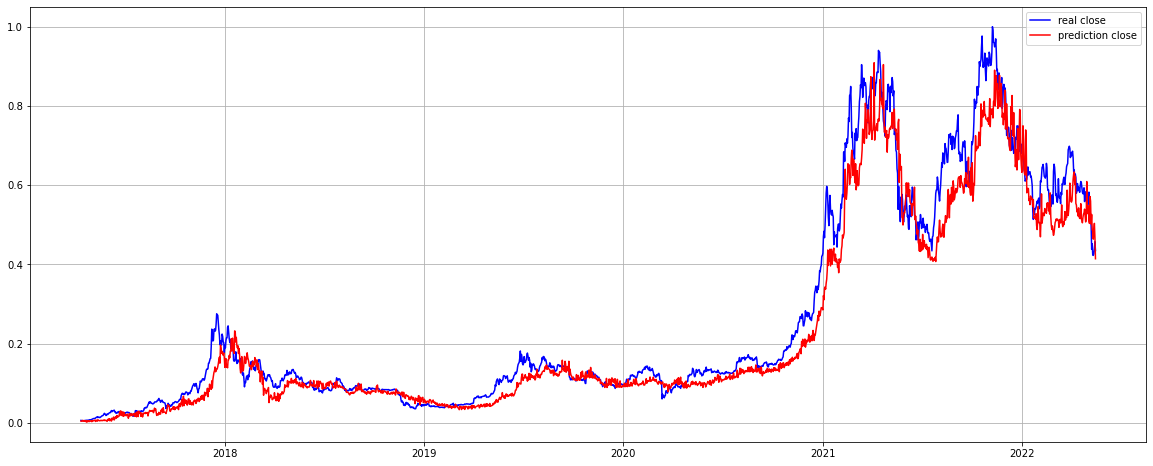

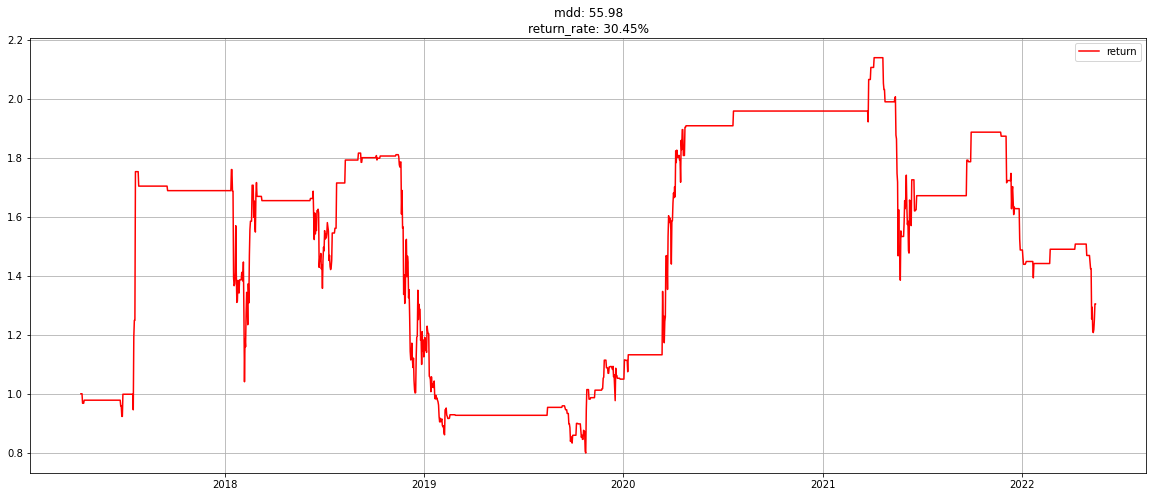

In [8]:
result_df = backtest_lstm_1d(df, 100, 1)

In [ ]:
analysis_return(result_df)

In [9]:
result_df.to_csv("0618_1d_2017_LSTM.csv")

In [16]:
result_df = pd.read_csv("../LSTM/0618_1d_2017_LSTM.csv")

In [20]:
result_df

,Open,High,Low,Close,Volume,prediction_close,batch_open,trade,ror,cr,mdd
2017-04-11,0.006448,0.005949,0.006820,0.006443,0.005477,0.004729,0.006448,0,1.000000,1.000000,0.000000
2017-04-12,0.006594,0.005884,0.006972,0.006341,0.005470,0.004347,0.006594,0,1.000000,1.000000,0.000000
2017-04-13,0.006492,0.005808,0.005949,0.005753,0.010890,0.004654,0.006492,0,1.000000,1.000000,0.000000
2017-04-14,0.005904,0.005420,0.005964,0.005714,0.013564,0.006457,0.005904,1,0.967814,0.967814,3.218589
2017-04-15,0.005866,0.005413,0.006316,0.005761,0.002755,0.005831,0.005866,0,1.000000,0.967814,3.218589
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-12,0.423839,0.431725,0.395117,0.422822,0.001249,0.463935,0.423839,1,0.997601,1.207405,43.548336
2022-05-13,0.422984,0.443688,0.427170,0.426620,0.000657,0.488213,0.422984,1,1.008597,1.217784,43.063030
2022-05-14,0.426779,0.433122,0.425214,0.438684,0.000409,0.503668,0.426779,1,1.027895,1.251754,41.474785
2022-05-15,0.438840,0.449400,0.438126,0.457324,0.000436,0.468504,0.438840,1,1.042120,1.304478,39.009703


In [18]:
result_df.set_index('Unnamed: 0', inplace = True)
result_df.index.name = None
result_df.index = pd.to_datetime(result_df.index)

In [19]:
result_df

,Open,High,Low,Close,Volume,prediction_close,batch_open,trade,ror,cr,mdd
2017-04-11,0.006448,0.005949,0.006820,0.006443,0.005477,0.004729,0.006448,0,1.000000,1.000000,0.000000
2017-04-12,0.006594,0.005884,0.006972,0.006341,0.005470,0.004347,0.006594,0,1.000000,1.000000,0.000000
2017-04-13,0.006492,0.005808,0.005949,0.005753,0.010890,0.004654,0.006492,0,1.000000,1.000000,0.000000
2017-04-14,0.005904,0.005420,0.005964,0.005714,0.013564,0.006457,0.005904,1,0.967814,0.967814,3.218589
2017-04-15,0.005866,0.005413,0.006316,0.005761,0.002755,0.005831,0.005866,0,1.000000,0.967814,3.218589
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-12,0.423839,0.431725,0.395117,0.422822,0.001249,0.463935,0.423839,1,0.997601,1.207405,43.548336
2022-05-13,0.422984,0.443688,0.427170,0.426620,0.000657,0.488213,0.422984,1,1.008597,1.217784,43.063030
2022-05-14,0.426779,0.433122,0.425214,0.438684,0.000409,0.503668,0.426779,1,1.027895,1.251754,41.474785
2022-05-15,0.438840,0.449400,0.438126,0.457324,0.000436,0.468504,0.438840,1,1.042120,1.304478,39.009703


In [26]:
result_ma = backtest_ma(result_df)
result_rsi = backtest_rsi(result_df)
result_noise = backtest_noise(result_df)
result_ma_rsi = backtest_ma_and_rsi(result_df)
result_ma_noise = backtest_ma_and_noise(result_df)
result_noise_rsi = backtest_noise_and_rsi(result_df)
result_ma_noise_rsi = backtest_ma_and_rsi_and_noise(result_df)

In [28]:
result_ma['cr']

2017-04-11    1.000000
2017-04-12    1.000000
2017-04-13    1.000000
2017-04-14    1.000000
2017-04-15    1.000000
                ...   
2022-05-12    0.933429
2022-05-13    0.933429
2022-05-14    0.933429
2022-05-15    0.941292
2022-05-16    0.941292
Name: cr, Length: 1862, dtype: float64

In [29]:
result_df['cr']

2017-04-11    1.000000
2017-04-12    1.000000
2017-04-13    1.000000
2017-04-14    0.967814
2017-04-15    0.967814
                ...   
2022-05-12    1.207405
2022-05-13    1.217784
2022-05-14    1.251754
2022-05-15    1.304478
2022-05-16    1.304478
Name: cr, Length: 1862, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error
y=result_df['Close']
y_pred=result_df['prediction_close']
RMSE = mean_squared_error(y, y_pred)**0.5
print(RMSE)

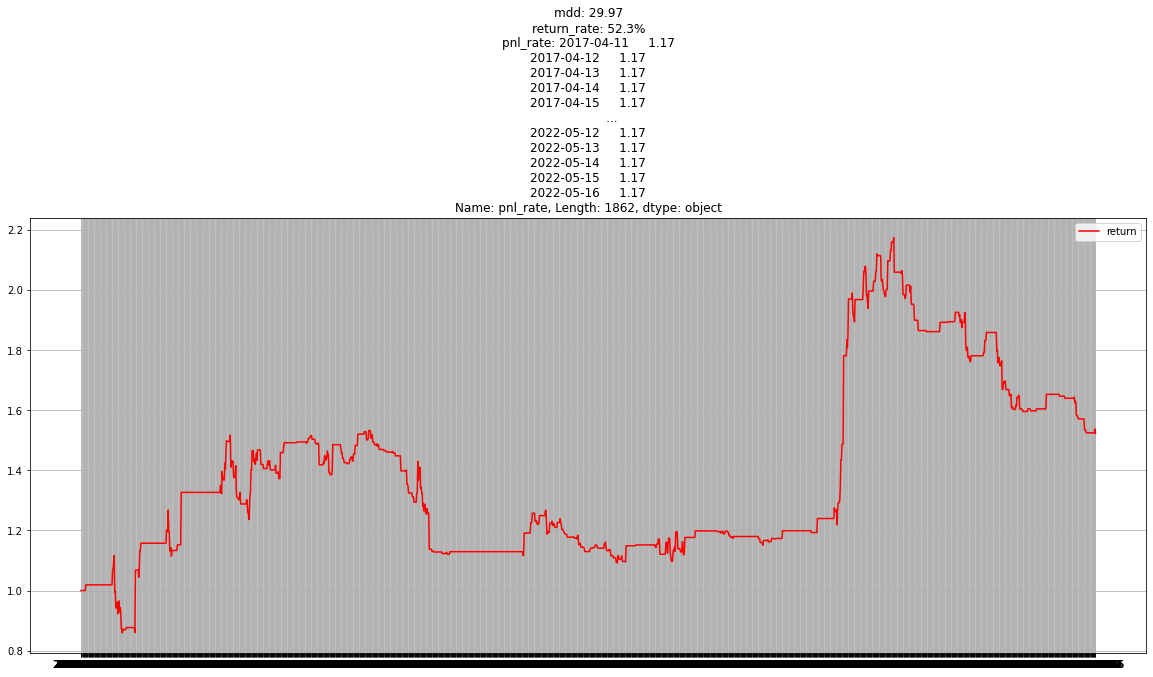

{'trade_rate': ' 21.92%', 'success_rate': ' 31.25%', 'pnl_rate': ' 0.23', 'mdd': ' 14.38%', 'cr': '-13.83%'}
{'trade_rate': ' 39.51%', 'success_rate': ' 46.88%', 'pnl_rate': ' 0.43', 'mdd': ' 10.13%', 'cr': '-10.85%'}
{'trade_rate': ' 2.68%', 'success_rate': ' 75.00%', 'pnl_rate': ' 8.86', 'mdd': ' 1.15%', 'cr': ' 9.21%'}
{'trade_rate': ' 20.83%', 'success_rate': ' 65.00%', 'pnl_rate': ' 4.21', 'mdd': ' 6.76%', 'cr': ' 80.23%'}


In [17]:
result_ma = backtest_ma(result_df)
plot_return(result_ma)

print(get_result_loss_1(result_ma))
print(get_result_loss_2(result_ma))
print(get_result_profit_1(result_ma))
print(get_result_profit_2(result_ma))

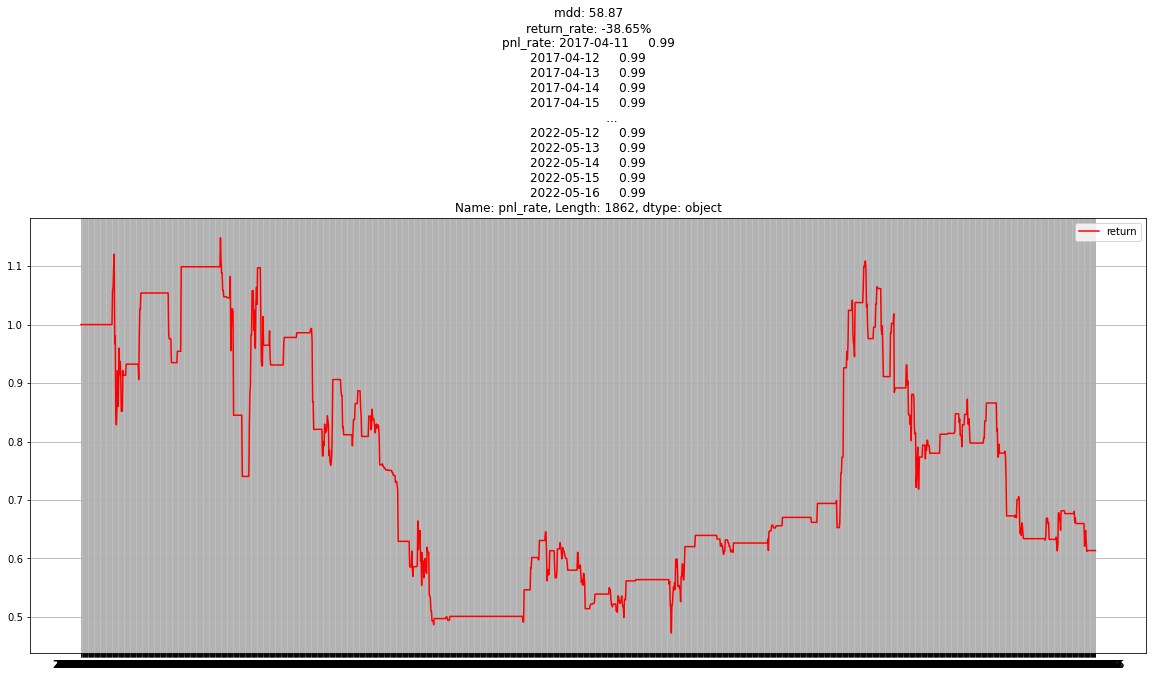

{'trade_rate': ' 39.73%', 'success_rate': ' 51.72%', 'pnl_rate': ' 0.68', 'mdd': ' 29.41%', 'cr': '-22.16%'}
{'trade_rate': ' 25.93%', 'success_rate': ' 33.33%', 'pnl_rate': ' 0.36', 'mdd': ' 20.31%', 'cr': '-22.82%'}
{'trade_rate': ' 2.68%', 'success_rate': ' 75.00%', 'pnl_rate': ' 10.05', 'mdd': ' 1.92%', 'cr': ' 18.03%'}
{'trade_rate': ' 17.19%', 'success_rate': ' 63.64%', 'pnl_rate': ' 2.63', 'mdd': ' 11.98%', 'cr': ' 61.87%'}


In [15]:
result_rsi = backtest_rsi(result_df)
plot_return(result_rsi)

print(get_result_loss_1(result_rsi))
print(get_result_loss_2(result_rsi))
print(get_result_profit_1(result_rsi))
print(get_result_profit_2(result_rsi))

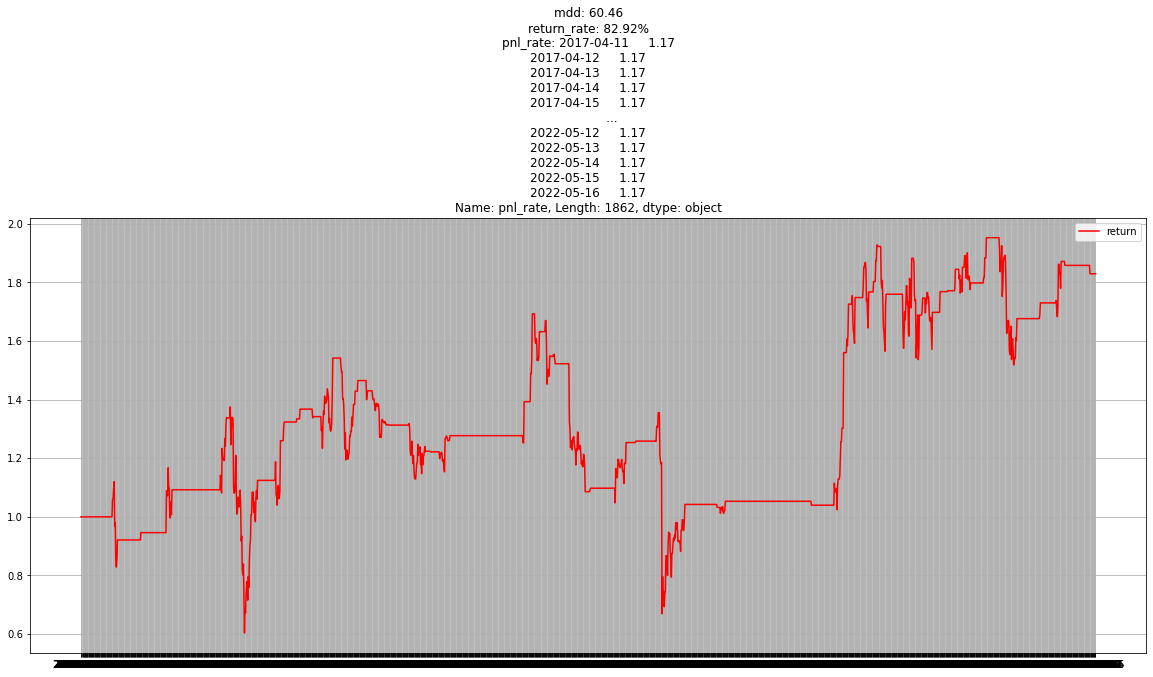

{'trade_rate': ' 57.53%', 'success_rate': ' 52.38%', 'pnl_rate': ' 1.01', 'mdd': ' 18.38%', 'cr': '-3.52%'}
{'trade_rate': ' 41.98%', 'success_rate': ' 55.88%', 'pnl_rate': ' 0.81', 'mdd': ' 22.23%', 'cr': '-11.39%'}
{'trade_rate': ' 2.68%', 'success_rate': ' 75.00%', 'pnl_rate': ' 10.05', 'mdd': ' 1.92%', 'cr': ' 18.03%'}
{'trade_rate': ' 19.79%', 'success_rate': ' 63.16%', 'pnl_rate': ' 2.85', 'mdd': ' 11.98%', 'cr': ' 82.52%'}


In [19]:
result_noise = backtest_noise(result_df)
plot_return(result_noise)

print(get_result_loss_1(result_noise))
print(get_result_loss_2(result_noise))
print(get_result_profit_1(result_noise))
print(get_result_profit_2(result_noise))

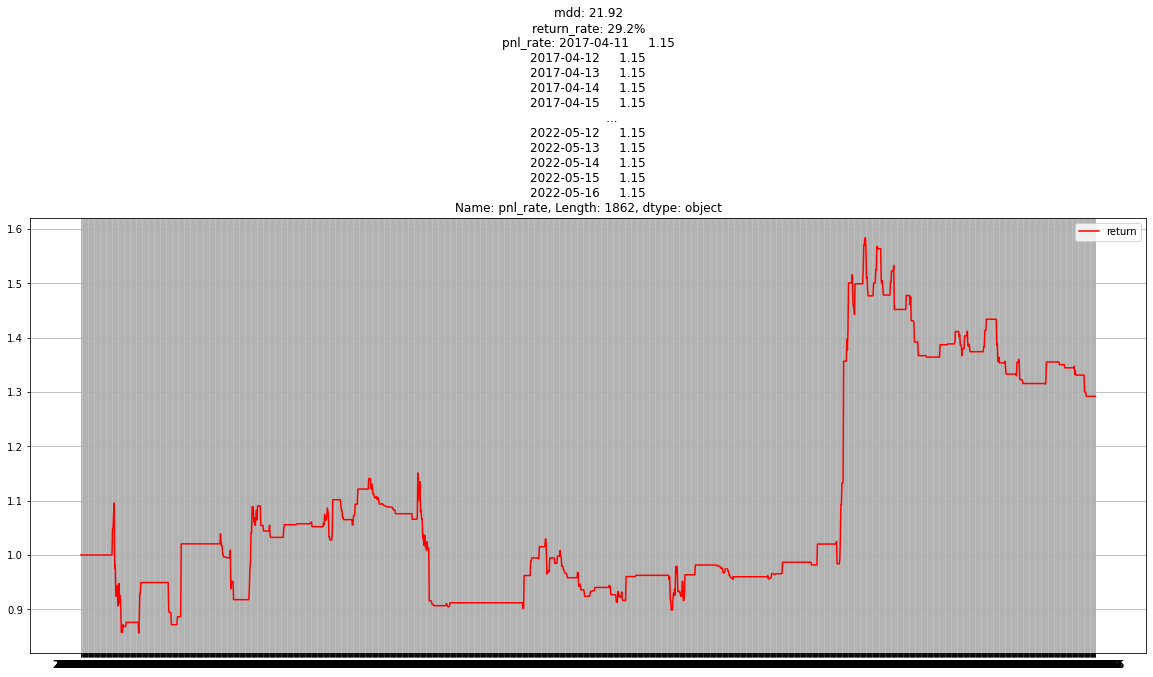

{'trade_rate': ' 13.70%', 'success_rate': ' 30.00%', 'pnl_rate': ' 0.24', 'mdd': ' 11.00%', 'cr': '-10.42%'}
{'trade_rate': ' 16.05%', 'success_rate': ' 30.77%', 'pnl_rate': ' 0.37', 'mdd': ' 3.54%', 'cr': '-5.25%'}
{'trade_rate': ' 2.68%', 'success_rate': ' 75.00%', 'pnl_rate': ' 8.86', 'mdd': ' 1.15%', 'cr': ' 9.21%'}
{'trade_rate': ' 17.19%', 'success_rate': ' 63.64%', 'pnl_rate': ' 3.81', 'mdd': ' 6.76%', 'cr': ' 61.92%'}


In [20]:
result_ma_rsi = backtest_ma_and_rsi(result_df)
plot_return(result_ma_rsi)

print(get_result_loss_1(result_ma_rsi))
print(get_result_loss_2(result_ma_rsi))
print(get_result_profit_1(result_ma_rsi))
print(get_result_profit_2(result_ma_rsi))

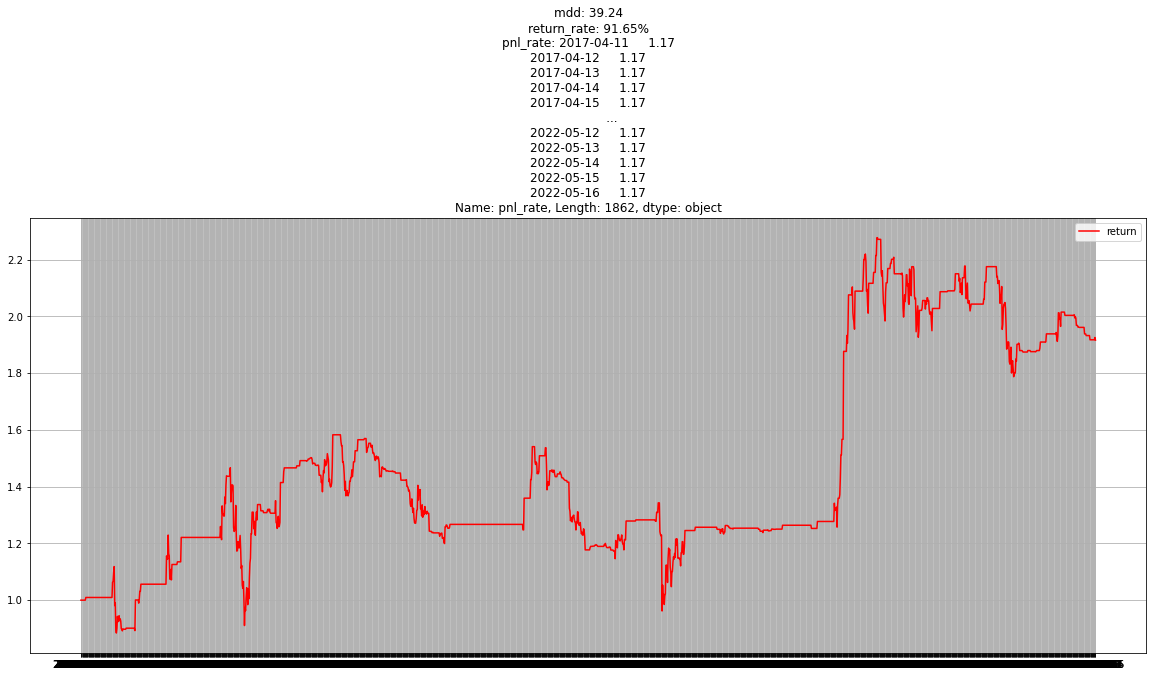

{'trade_rate': ' 64.38%', 'success_rate': ' 51.06%', 'pnl_rate': ' 0.86', 'mdd': ' 12.77%', 'cr': '-7.87%'}
{'trade_rate': ' 58.02%', 'success_rate': ' 53.19%', 'pnl_rate': ' 0.70', 'mdd': ' 15.94%', 'cr': '-10.80%'}
{'trade_rate': ' 2.68%', 'success_rate': ' 75.00%', 'pnl_rate': ' 9.60', 'mdd': ' 1.54%', 'cr': ' 13.58%'}
{'trade_rate': ' 20.83%', 'success_rate': ' 65.00%', 'pnl_rate': ' 3.34', 'mdd': ' 9.39%', 'cr': ' 81.69%'}


In [21]:
result_ma_noise = backtest_ma_and_noise(result_df)
plot_return(result_ma_noise)

print(get_result_loss_1(result_ma_noise))
print(get_result_loss_2(result_ma_noise))
print(get_result_profit_1(result_ma_noise))
print(get_result_profit_2(result_ma_noise))

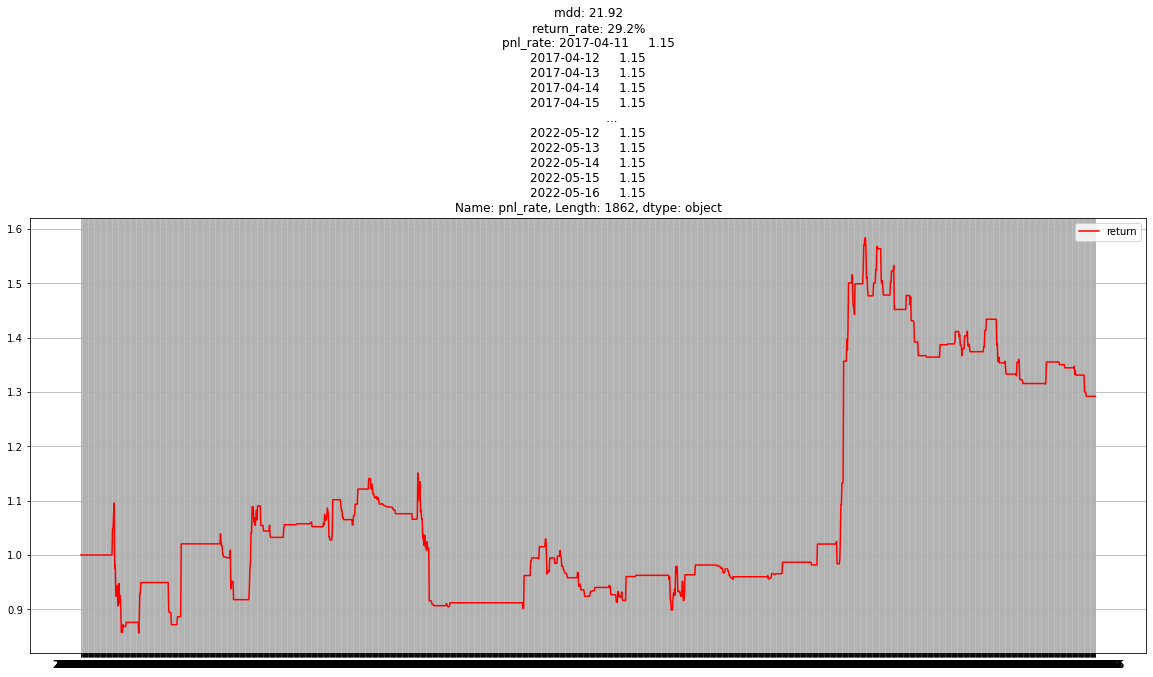

{'trade_rate': ' 34.25%', 'success_rate': ' 48.00%', 'pnl_rate': ' 0.79', 'mdd': ' 23.04%', 'cr': '-12.81%'}
{'trade_rate': ' 11.11%', 'success_rate': ' 33.33%', 'pnl_rate': ' 0.31', 'mdd': ' 15.81%', 'cr': '-11.91%'}
{'trade_rate': ' 2.68%', 'success_rate': ' 75.00%', 'pnl_rate': ' 10.05', 'mdd': ' 1.92%', 'cr': ' 18.03%'}
{'trade_rate': ' 16.15%', 'success_rate': ' 61.29%', 'pnl_rate': ' 2.32', 'mdd': ' 11.98%', 'cr': ' 47.13%'}


In [22]:
result_noise_rsi = backtest_noise_and_rsi(result_df)
plot_return(result_ma_rsi)

print(get_result_loss_1(result_noise_rsi))
print(get_result_loss_2(result_noise_rsi))
print(get_result_profit_1(result_noise_rsi))
print(get_result_profit_2(result_noise_rsi))

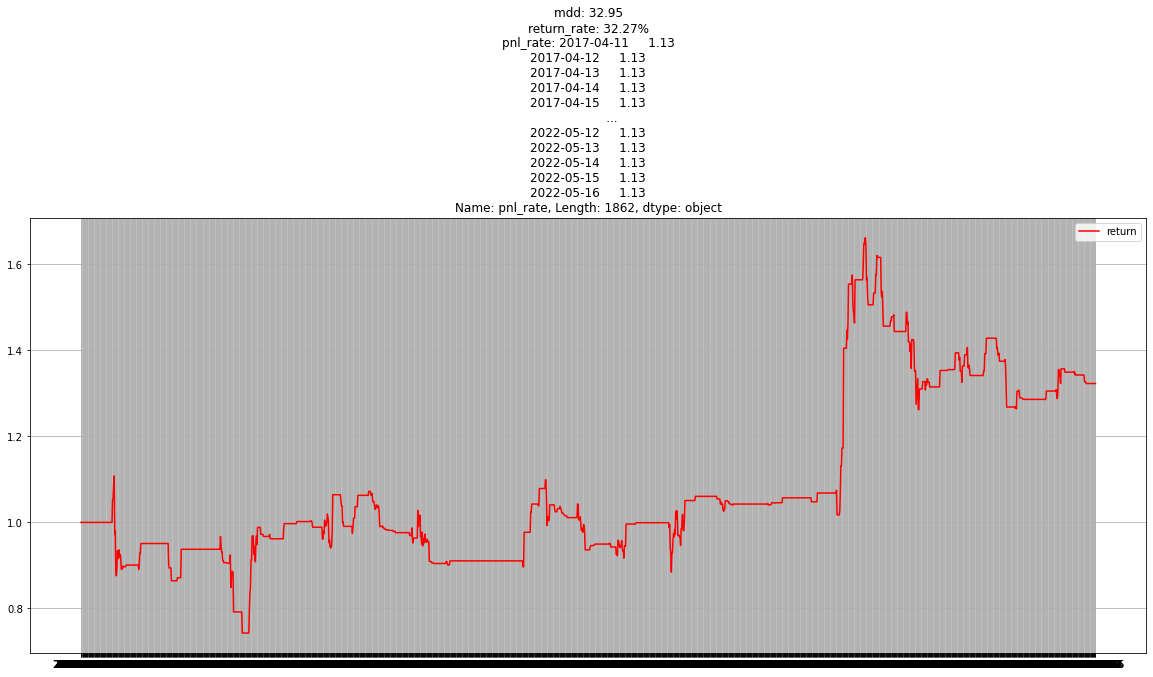

{'trade_rate': ' 36.99%', 'success_rate': ' 48.15%', 'pnl_rate': ' 0.67', 'mdd': ' 15.20%', 'cr': '-11.04%'}
{'trade_rate': ' 19.75%', 'success_rate': ' 31.25%', 'pnl_rate': ' 0.33', 'mdd': ' 9.29%', 'cr': '-8.50%'}
{'trade_rate': ' 2.68%', 'success_rate': ' 75.00%', 'pnl_rate': ' 9.60', 'mdd': ' 1.54%', 'cr': ' 13.58%'}
{'trade_rate': ' 17.19%', 'success_rate': ' 63.64%', 'pnl_rate': ' 2.86', 'mdd': ' 9.39%', 'cr': ' 54.52%'}


In [23]:
result_ma_noise_rsi = backtest_ma_and_rsi_and_noise(result_df)
plot_return(result_ma_noise_rsi)

print(get_result_loss_1(result_ma_noise_rsi))
print(get_result_loss_2(result_ma_noise_rsi))
print(get_result_profit_1(result_ma_noise_rsi))
print(get_result_profit_2(result_ma_noise_rsi))

# 문제점 (5월 12일 09:38 기준)
###
### MinMax Scaling으로 데이터셋을 전처리한 후 모든 내용을 일괄 수행하다 보니, 
### 수익률 측정도 MinMax Scaling 처리된 값을 기준으로 진행되어, 실제 값과 다를 수 있음
### 수익률을 개선하기 위해 LSTM의 unit수를 대폭 증가시키고, overfitting을 방지하기 위해 Dropout을 사용했으나, 이전의 모델보다 현저히 낮은 수익률을 보이고 있음.

In [4]:
df

,Open,High,Low,Close,Volume,Datetime
Datetime,,,,,,
2017-01-01,966.34,1005.00,960.53,998.80,6.579904e+06,2017-01-01
2017-01-02,997.75,1032.00,990.01,1014.10,8.190255e+06,2017-01-02
2017-01-03,1011.44,1039.00,999.99,1036.99,8.955193e+06,2017-01-03
2017-01-04,1035.51,1139.89,1028.56,1122.56,2.325716e+07,2017-01-04
2017-01-05,1114.38,1136.72,885.41,994.02,3.503690e+07,2017-01-05
...,...,...,...,...,...,...
2022-05-12,29077.90,30257.00,26631.00,29020.70,9.644756e+05,2022-05-12
2022-05-13,29020.80,31072.60,28730.40,29274.30,5.076201e+05,2022-05-13
2022-05-14,29274.20,30352.20,28602.30,30079.80,3.157569e+05,2022-05-14


In [7]:
scaler_x = MinMaxScaler()
df[['Open','High','Low','Volume']] = scaler_x.fit_transform(df[['Open','High','Low','Volume']])

scaler_y = MinMaxScaler()
df['Close'] = scaler_y.fit_transform(df['Close'].values.reshape(-1,1))

In [8]:
df

,Open,High,Low,Close,Volume,Datetime
Datetime,,,,,,
2017-01-01,0.002810,0.002663,0.003194,0.003145,0.008520,2017-01-01
2017-01-02,0.003281,0.003059,0.003644,0.003374,0.010605,2017-01-02
2017-01-03,0.003486,0.003162,0.003796,0.003717,0.011595,2017-01-03
2017-01-04,0.003846,0.004641,0.004232,0.004998,0.030113,2017-01-04
2017-01-05,0.005027,0.004595,0.002047,0.003073,0.045365,2017-01-05
...,...,...,...,...,...,...
2022-05-12,0.423839,0.431725,0.395117,0.422822,0.001249,2022-05-12
2022-05-13,0.422984,0.443688,0.427170,0.426620,0.000657,2022-05-13
2022-05-14,0.426779,0.433122,0.425214,0.438684,0.000409,2022-05-14


In [18]:
rescaled_actual = scaler_y.inverse_transform(df['Close'][0].reshape(-1,1))

#rescaled_pred = scaler1.inverse_transform(np.array(pred).reshape(-1,1))

In [15]:
rescaled_actual

array([[  998.8 ],
       [ 1014.1 ],
       [ 1036.99],
       ...,
       [30079.8 ],
       [31324.4 ],
       [29851.5 ]])

In [19]:
rescaled_actual

array([[998.8]])

In [13]:
#result_df.index.name = None

In [117]:
#result_df.index = pd.to_datetime(result_df.index)

In [118]:
#result_df.rename(columns={'o':'Open','h':'High', 'l':'Low', 'c':'Close'}, inplace=True)

In [119]:
#result_df.index = datetime(result_df[result_df.columns[0]])

In [120]:
#result_df

In [121]:
#plot_return(result_df)